<a href="https://colab.research.google.com/github/mldev92/mldev92/blob/main/%7C_NG_1_%7C_YOLOv8_Stas_Bridge_IT_%D0%A3%D0%98%D0%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Проверка видеокарты

YOLO модели большие и долго обучаются.

Для параллелизации вычислений необходима видеокрта. Она ускоряет процесс обучения в разы.

## Установка библиотек

In [ ]:
!pip install ultralytics==8.0.227

## Импорт библиотек

In [ ]:
import os # импортируем библиотеку для взаимодействия с операционной системой
import cv2 # импортируем библиотеку для работы с изображениями
import random # импортируем библиотеку для генерации рандомных данных
import numpy as np # импортируем библиотеку линейной алгебры
import matplotlib.pyplot as plt # импортируем библиотеку для визуализации данных

from PIL import Image # импортируем модуль для работы с изображениями
from zipfile import ZipFile # импортируем класс для работы с zip архивами
from ultralytics import YOLO # импортируем класс модели
from ultralytics.engine.results import Results # импортируем класс результата, возвращаемого в списке после предикта

from typing import Sequence, Generator, Literal, TypeAlias # импортируем дополнительные типы для лучшей читаемости кода

In [ ]:
# Определение констант
BASE_DIR = "dataset"
RES_DIR = "runs/detect/train3"
# ANNOTATIONS_PATH = "dataset/annotation/annotation/YOLO-format"
IMAGES_PATH = "dataset/images/images"

DATASET_DIR = "dataset/data"
ANNOTATIONS_PATH = f"{DATASET_DIR}/labels"

DATASET_LABELS_DIR  = f"{DATASET_DIR}/labels"
DATASET_IMAGES_DIR  = f"{DATASET_DIR}/images"
DATASET_CONFIG_PATH = f"{DATASET_DIR}/dataset.yaml"

VAL_SIZE = 0.2
TEST_SIZE = 0.1

ExtractedResults: TypeAlias = dict[str, tuple[list, np.ndarray]]

## Создание вспомогательных функций для отображения фото

In [ ]:
# функция для загрузки изображения
def get_image(filename: str, dir: str = IMAGES_PATH) -> np.ndarray:
  """
Загрузка изображения в массив numpy по пути.

filename: имя файла
dir: каталог с файлом
returns: изображение в виде массива numpy.ndarray
raises: None
"""
  return cv2.imread(f"{dir}/{filename}")

In [ ]:
# функция для загрузки лейблов
def get_annotation(filename: str, dir: str = ANNOTATIONS_PATH) -> list[list[float]]:
  """
Загрузка аннотации по пути.

filename: имя файла
dir: каталог файлов
returns: список ограничивающих рамок (bounding boxes)
raises: None
"""
  with open(f"{dir}/{filename}") as file:
    text = file.read() # читаем содержимое файла

  boxes = text.split("\n") # получаем список с отдельными bounding box-ами деля строку по символу переноса
  if "" in boxes: boxes.remove("") # удаляем пробел если он сушествет
  return [list(map(float, box.split())) for box in boxes] # для каждого элемента преобразовываем строку в список с числами с плавающей точкой

In [ ]:
# функция для извлечения точек из данных о bounding box и изменения их значений под размер конкретного изображения
def make_points(image_w: int, image_h: int, box: list[float]) -> tuple[tuple[int, int], tuple[int, int]]:
  """
Извлечение двух точек из ограничительной рамки и масштабирование их для определенного размера изображения.

image_w: ширина изображения
image_h: высота изображения
box: ограничивающий прямоугольник
returns: кортеж с двумя точками
raises: None
"""
  w_offset = box[3]
  h_offset = box[4]
  points1 = (int((box[1]-w_offset/2)*image_w), int((box[2]-h_offset/2)*image_h))
  points2 = (int((box[1]+w_offset/2)*image_w), int((box[2]+w_offset/2)*image_h))
  return points1, points2

In [ ]:
# функция для отрисовки прямоугольника на изображении
def draw_boxes(image: np.ndarray, boxes: list[list[float]]) -> np.ndarray:
  """
Рисование ограничивающих рамок на изображении.

image: изображение в виде массива numpy.ndarray
box: список ограничивающих рамок
returns: изображение в виде массива numpy.ndarray
raises: None
"""
  new_image = image.copy() # копируем оригинальное изображение
  for box in boxes:
    points = make_points(*image.shape[-2::-1], box) # извлекаем точки
    cv2.rectangle(new_image, points[0], points[1], (255, 0, 0), 4) # рисуем прямоугольник
  return new_image

In [ ]:
# функция для сравнения изображений с исходными и предсказанными bounding box-ами
def compare_with_original(model_results: ExtractedResults, set_type: Literal["train", "val", "test"]) -> None:
  """
Отображение 6 изображений (3 пары рядом друг с другом) для сравнения исходного расположения ограничивающих рамок с прогнозируемым.

model_results: TypeAlias = dict[str, tuple[list, np.ndarray]]
set_type: выборка датасета, из которой нужно получить данные. Один из ["train", "val", "test"]
returns: None
raises: None
"""
  images_names = random.choices(list(model_results.keys()), k=3) # рандомно выбираем 3 имнени изображений из списка предсказанных
  fig, axes = plt.subplots(3, 2, figsize=(16, 14))                 # создаём полотна для графиков

  for i, name in enumerate(images_names):
    img = get_image(name, f"{DATASET_IMAGES_DIR}/{set_type}")                                    # извлекаем оригинал изображения
    s_name = ".".join(name.split('.')[:-1])
    annotation = get_annotation(f"{s_name}.txt", f"{DATASET_LABELS_DIR}/{set_type}") # извлекаем лейбл
    new_img = draw_boxes(img, annotation)                        # отрисовываем ограничивающие рамки
    predicted_img = model_results[name][1]                       # извлекаем готовое изображение из списка предсказанных

    axes[i][0].axis("off")
    axes[i][0].imshow(new_img)
    axes[i][1].axis("off")
    axes[i][1].imshow(predicted_img)

  axes[0][0].set_title("Original BB layout", {"fontsize": 20})
  axes[0][1].set_title("YOLO predictions",   {"fontsize": 20})
  fig.tight_layout()
  fig.show()

## Создание вспомогательных функций для работы с моделью

In [ ]:
# функция для извлечения предсказаний
def extract_predictions(predictions_generator: Generator[Results, None, None]) -> ExtractedResults:
  """
Извлечение прогнозов из генератора.

predictions_generator: генератор, дающий результаты прогнозирования
returns: TypeAlias = dict[str, tuple[list, np.ndarray]]
raises: None
"""
  results = {}
  predicted_count = 0

  for i, pred in enumerate(predictions_generator):
    img = pred.path.split("/")[-1]            # извлекаем имя файла из полного пути
    classes = pred.boxes.cls.tolist()         # извлекаем предсказанные объекты в список
    predicted_count += classes.count(0) # увеличиваем счётчик людей на количество найденных людей

    if classes: results[img] = (classes, pred.plot()) # добавляем предсказание к результатам если найден хотя бы один объект

  return results, predicted_count

## Создание структуры датасета

In [ ]:
# !pip install gdown

# import gdown

# # https://drive.google.com/file/d/1ryqw6Pl6zm9DYPecrkReYElOdOYQjadB/view?usp=drive_link

# file_id = '1ryqw6Pl6zm9DYPecrkReYElOdOYQjadB'  # Замените на фактический идентификатор файла
# destination = '/content/dataset.zip'  # Путь, куда будет сохранен загруженный файл

# gdown.download(f'https://drive.google.com/uc?id={file_id}', destination, quiet=False)

In [ ]:
!rm -r /content/dataset

In [ ]:
# Скачивание датасета в dataset.zip
# !wget https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/6KMoVMsm0DtlKw/12_class_NG_121_YOLO.zip -O dataset.zip

In [ ]:
# Извлечение датасета в директорию {BASE_DIR}
with ZipFile("NG_dataset.zip", "r") as zip_file:
   zip_file.extractall(BASE_DIR)

In [ ]:
import os

# Задайте путь к папке с файлами
directory = '/content/dataset/images/images'
directory2 = '/content/dataset/data/labels'

# Функция для удаления всех точек в имени файла, кроме последней перед расширением
def rename_files_in_directory(directory):
    for filename in os.listdir(directory):
        # Пропускаем файлы, которые не являются файлами (например, директории)
        if not os.path.isfile(os.path.join(directory, filename)):
            continue

        # Разделяем имя файла и его расширение
        name, ext = os.path.splitext(filename)

        # Убираем все точки из имени файла
        new_name = name.replace('.', '')

        # Формируем новое имя файла
        new_filename = f"{new_name}{ext}"

        # Переименовываем файл
        os.rename(os.path.join(directory, filename), os.path.join(directory, new_filename))

# Вызов функции
rename_files_in_directory(directory)
rename_files_in_directory(directory2)


In [ ]:
# Создание списков с названиями файлов
annotations = sorted(os.listdir(ANNOTATIONS_PATH), key=lambda x: str(x.split(".")[0])) # извлечение сортированного по имени списка имён лейблов
images = sorted(os.listdir(IMAGES_PATH), key=lambda x: str(x.split(".")[0])) # извлечение сортированного по имени списка имён изображений

assert len(annotations) == len(images) # проверка совпадения длин обоих списков
assert [name.split(".")[0] for name in annotations] == [name.split(".")[0] for name in images] # проверка соответствия имён изображений и лейблов

При обучении YOLOv8 мы должны описать структуру датасета в `.yaml` файле конфигурации.

Путь до этого файла будет передаваться в функцию обучения модели.


Константы с путями до директорий изображений и лейблов уже определены.

In [ ]:
# Визуализация ранее инициализированных констант
print(f"{DATASET_DIR=}")
print(f"{DATASET_LABELS_DIR=}")
print(f"{DATASET_IMAGES_DIR=}")

DATASET_DIR='dataset/data'
DATASET_LABELS_DIR='dataset/data/labels'
DATASET_IMAGES_DIR='dataset/data/images'


#### Создадим их и субдиректории с делением на выборки.

In [ ]:
# Создание директорий под тренировочную, тестовую и валидационную выборки
# os.mkdir(DATASET_DIR)
# os.mkdir(DATASET_LABELS_DIR)
os.mkdir(DATASET_IMAGES_DIR)

os.mkdir(f"{DATASET_LABELS_DIR}/train")
os.mkdir(f"{DATASET_LABELS_DIR}/val")
os.mkdir(f"{DATASET_LABELS_DIR}/test")

os.mkdir(f"{DATASET_IMAGES_DIR}/train")
os.mkdir(f"{DATASET_IMAGES_DIR}/val")
os.mkdir(f"{DATASET_IMAGES_DIR}/test")

#### Опишем структуру в файле конфигурации.

In [ ]:
# Добавим описание структуры датасета

dataset_configuration = f"""
path: /content/{DATASET_DIR}
train: images/train
val: images/val

names:
  0: NG

"""

with open(DATASET_CONFIG_PATH, "w") as file:
  file.write(dataset_configuration)

print(f"Конфигурация \n\"\"\"{dataset_configuration}\"\"\" записана в {DATASET_CONFIG_PATH}")

Конфигурация 
"""
path: /content/dataset/data
train: images/train
val: images/val

names:
  0: NG

""" записана в dataset/data/dataset.yaml


#### Теперь поделим данные на выборки.

In [ ]:
# Визуализация ранее инициализированных констант
print(f"{VAL_SIZE=}")
print(f"{TEST_SIZE=}")

VAL_SIZE=0.2
TEST_SIZE=0.1


In [ ]:
# Перемешивание данных перед переносом
data_filenames = list(zip(annotations, images)) # создаём список с кортежами из имён лейблов и изображений соответственно:
                                               #   [(1.txt, 1.png), (2.txt, 2.png)]
random.shuffle(data_filenames) # рандомно перемешиваем данные

In [ ]:
# Определение размера выборок
train_end_point = int(len(data_filenames) * (1 - VAL_SIZE - TEST_SIZE)) # получаем индекс конца тренировочной выборки
val_end_point = int(len(data_filenames) * (1 - TEST_SIZE)) # получаем индекс конца валидационной выборки

# Деление на выборки
TRAIN_FILENAMES = data_filenames[:train_end_point] # получаем срез с кортежами для тренировочной выборки
VAL_FILENAMES = data_filenames[train_end_point:val_end_point] # получаем срез с кортежами для валидационной выборки
TEST_FILENAMES = data_filenames[val_end_point:] # получаем срез с кортежами для тестовой выборки

#### Перенесём файлы в новые директории.

Перенести файл можно просто переименовав его вместе с путём до него.

Например переименовав файл

c

`/base/some_dir/file.txt`

на

`/base/another_dir/file.txt`

он будет просто перенесён из директории "some_dir" в директорию "another_dir"

In [ ]:
# Перенос файлов в {TRAIN_FILENAMES}
for label_filename, image_filename in TRAIN_FILENAMES:
  os.rename(f"{ANNOTATIONS_PATH}/{label_filename}", f"{DATASET_LABELS_DIR}/train/{label_filename}")
  os.rename(f"{IMAGES_PATH}/{image_filename}", f"{DATASET_IMAGES_DIR}/train/{image_filename}")

# Перенос файлов в {VAL_FILENAMES}
for label_filename, image_filename in VAL_FILENAMES:
  os.rename(f"{ANNOTATIONS_PATH}/{label_filename}", f"{DATASET_LABELS_DIR}/val/{label_filename}")
  os.rename(f"{IMAGES_PATH}/{image_filename}", f"{DATASET_IMAGES_DIR}/val/{image_filename}")

# Перенос файлов в {TEST_FILENAMES}
for label_filename, image_filename in TEST_FILENAMES:
    os.rename(f"{ANNOTATIONS_PATH}/{label_filename}", f"{DATASET_LABELS_DIR}/test/{label_filename}")
    os.rename(f"{IMAGES_PATH}/{image_filename}", f"{DATASET_IMAGES_DIR}/test/{image_filename}")

In [ ]:
# Тесты на целостность перенесённых данных

# Проверка относительного размера выборок
assert int(len(os.listdir(f"{DATASET_LABELS_DIR}/train")) / ((1 - VAL_SIZE - TEST_SIZE)*100)) == \
       int(len(os.listdir(f"{DATASET_LABELS_DIR}/val"))   / (VAL_SIZE*100)) == \
       int(len(os.listdir(f"{DATASET_LABELS_DIR}/test"))  / (TEST_SIZE*100))

# Проверка размера фотографий и лейблов каждой выборки
assert len(os.listdir(f"{DATASET_LABELS_DIR}/train")) == len(os.listdir(f"{DATASET_IMAGES_DIR}/train")) # проверка тренировочной выборки
assert len(os.listdir(f"{DATASET_LABELS_DIR}/val")) == len(os.listdir(f"{DATASET_IMAGES_DIR}/val")) # проверка валидационной выборки
assert len(os.listdir(f"{DATASET_LABELS_DIR}/test")) == len(os.listdir(f"{DATASET_IMAGES_DIR}/test")) # проверка тестовой выборки

## Проверка предобученной модели

In [ ]:
model = YOLO("yolov8m.pt")                                   # создадим инстанс модели
assert model.names[0] == "person"                            # удостоверимся, что нулевым классом является человек
predictions_generator = model.predict(                       # создадим генератор предсказаний для тестовой выборки
                            f"{DATASET_IMAGES_DIR}/test",
                            stream=True,
                            verbose=False,
                            )

In [ ]:
results, predicted_count = extract_predictions(predictions_generator) # запустим процесс извлечения предсказаний из генератора

In [ ]:
# Подсчёт человек в тестовой выборке
all_bboxes = []
for annotation_filename in os.listdir(f"{DATASET_LABELS_DIR}/test"):
  all_bboxes += get_annotation(annotation_filename, f"{DATASET_LABELS_DIR}/test")

total_count = len(all_bboxes)

In [ ]:
predicted_count

0

## Обучение модели

In [ ]:
# Пересоздадим инстанс модели
model = YOLO("yolov8m.pt")

In [ ]:
res = model.train(data=DATASET_CONFIG_PATH, epochs=100)

New https://pypi.org/project/ultralytics/8.2.51 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=dataset/data/dataset.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=Fal

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


AMP: checks passed ✅


train: Scanning /content/dataset/data/labels/train... 84 images, 0 backgrounds, 0 corrupt: 100%|██████████| 84/84 [00:00<00:00, 1776.41it/s]

train: New cache created: /content/dataset/data/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/dataset/data/labels/val... 24 images, 0 backgrounds, 0 corrupt: 100%|██████████| 24/24 [00:00<00:00, 859.39it/s]

val: New cache created: /content/dataset/data/labels/val.cache


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      7.16G      1.652      3.056      1.603         33        640: 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]

                   all         24        119      0.263       0.37      0.214      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.33G      1.552      2.208      1.531         52        640: 100%|██████████| 6/6 [00:02<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

                   all         24        119      0.427      0.412       0.38      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100       7.3G       1.41       1.69      1.424         28        640: 100%|██████████| 6/6 [00:02<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

                   all         24        119      0.461      0.445      0.387      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.36G      1.415      1.626      1.463         15        640: 100%|██████████| 6/6 [00:03<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all         24        119      0.321      0.394      0.264      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      7.09G      1.371      1.492      1.323         48        640: 100%|██████████| 6/6 [00:02<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

                   all         24        119      0.266       0.21      0.134     0.0505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      7.34G      1.398      1.429      1.456         33        640: 100%|██████████| 6/6 [00:03<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all         24        119      0.432      0.336      0.281      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.35G      1.398      1.397      1.493         42        640: 100%|██████████| 6/6 [00:02<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         24        119      0.344      0.388      0.259      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      7.35G      1.456      1.387      1.508         45        640: 100%|██████████| 6/6 [00:02<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

                   all         24        119     0.0852      0.235       0.04     0.0137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      7.36G      1.505      1.561      1.548         43        640: 100%|██████████| 6/6 [00:02<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all         24        119      0.104      0.227     0.0631     0.0279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      7.37G      1.357      1.335      1.385         53        640: 100%|██████████| 6/6 [00:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

                   all         24        119      0.118      0.176     0.0628     0.0227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      7.35G       1.38      1.373      1.431         48        640: 100%|██████████| 6/6 [00:02<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all         24        119      0.105      0.361      0.082     0.0288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      7.36G       1.45      1.397      1.496         44        640: 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

                   all         24        119     0.0178     0.0924     0.0059    0.00165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100       7.3G      1.488      1.548      1.556         20        640: 100%|██████████| 6/6 [00:03<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         24        119    0.00287      0.101    0.00135   0.000471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      7.38G      1.497      1.415      1.522         35        640: 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

                   all         24        119    0.00691      0.126    0.00239     0.0011



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      7.37G      1.537      1.442      1.508         66        640: 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

                   all         24        119     0.0232      0.176     0.0114     0.0036



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.37G      1.539       1.46      1.483         43        640: 100%|██████████| 6/6 [00:02<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

                   all         24        119     0.0308      0.101      0.012     0.0031



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      7.34G      1.483      1.396      1.495         45        640: 100%|██████████| 6/6 [00:02<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

                   all         24        119     0.0274      0.193     0.0125    0.00348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      7.39G      1.447      1.317      1.454         35        640: 100%|██████████| 6/6 [00:03<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

                   all         24        119    0.00979      0.134    0.00478    0.00244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      7.36G      1.421      1.246       1.44         44        640: 100%|██████████| 6/6 [00:03<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

                   all         24        119     0.0242     0.0336    0.00817    0.00318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      7.35G      1.514      1.363      1.534         26        640: 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all         24        119     0.0204      0.269     0.0117     0.0047



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      7.34G      1.544      1.442      1.559         25        640: 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   all         24        119       0.02      0.227    0.00938    0.00348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      7.31G      1.428      1.443      1.464         26        640: 100%|██████████| 6/6 [00:03<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all         24        119     0.0063     0.0924    0.00221   0.000796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      7.36G      1.399       1.31      1.443         41        640: 100%|██████████| 6/6 [00:02<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         24        119    0.00582      0.252    0.00348     0.0013



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      7.34G      1.416      1.301      1.481         36        640: 100%|██████████| 6/6 [00:02<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

                   all         24        119     0.0161      0.235     0.0106    0.00298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100       7.3G        1.4      1.253      1.453         27        640: 100%|██████████| 6/6 [00:02<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         24        119       0.23      0.244      0.114     0.0433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      7.38G      1.344      1.155      1.408         24        640: 100%|██████████| 6/6 [00:02<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all         24        119      0.205     0.0756     0.0495     0.0185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      7.37G      1.262      1.128      1.352         39        640: 100%|██████████| 6/6 [00:02<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

                   all         24        119      0.129      0.185     0.0927      0.038



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      7.35G      1.401      1.166      1.428         55        640: 100%|██████████| 6/6 [00:02<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all         24        119      0.204       0.16     0.0817     0.0283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      7.34G      1.361      1.169      1.405         41        640: 100%|██████████| 6/6 [00:03<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all         24        119      0.207      0.199      0.115     0.0542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      7.33G      1.265      1.063      1.318         43        640: 100%|██████████| 6/6 [00:02<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all         24        119      0.247      0.176      0.114       0.05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      7.38G      1.327      1.084      1.394         35        640: 100%|██████████| 6/6 [00:03<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         24        119      0.281      0.202      0.158     0.0619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      7.38G       1.38      1.189       1.43         20        640: 100%|██████████| 6/6 [00:02<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

                   all         24        119      0.355      0.345      0.247      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      7.37G      1.255      1.037      1.389         39        640: 100%|██████████| 6/6 [00:03<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

                   all         24        119      0.318      0.437      0.277      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      7.38G      1.262     0.9934      1.361         36        640: 100%|██████████| 6/6 [00:03<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         24        119      0.272      0.387      0.272      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      7.32G       1.26      1.066      1.353         27        640: 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

                   all         24        119      0.292      0.496      0.298       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100       7.4G      1.216      1.008      1.293         89        640: 100%|██████████| 6/6 [00:02<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

                   all         24        119      0.395      0.361      0.284      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      7.35G      1.241      0.955      1.344         30        640: 100%|██████████| 6/6 [00:03<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all         24        119      0.318      0.429      0.318      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      7.36G      1.241     0.9779      1.309         43        640: 100%|██████████| 6/6 [00:02<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

                   all         24        119      0.593      0.361      0.381      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      7.34G      1.164       1.02      1.283         16        640: 100%|██████████| 6/6 [00:02<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all         24        119      0.523      0.361       0.37      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      7.39G      1.103     0.9206      1.275         30        640: 100%|██████████| 6/6 [00:03<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all         24        119      0.438       0.42      0.329      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      7.38G      1.164     0.9501      1.275         33        640: 100%|██████████| 6/6 [00:03<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         24        119      0.434      0.429      0.361      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      7.38G      1.123     0.9238      1.235         37        640: 100%|██████████| 6/6 [00:02<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

                   all         24        119       0.37      0.471      0.294      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      7.36G      1.121      0.911      1.272         29        640: 100%|██████████| 6/6 [00:03<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         24        119      0.352      0.487      0.329      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      7.36G      1.104     0.8561      1.239         25        640: 100%|██████████| 6/6 [00:02<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all         24        119      0.497      0.406      0.397      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      7.38G      1.102      0.864      1.218         23        640: 100%|██████████| 6/6 [00:02<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

                   all         24        119      0.407      0.336      0.314       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      7.35G      1.125     0.9269      1.274         45        640: 100%|██████████| 6/6 [00:02<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         24        119      0.469      0.387      0.329      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      7.34G      1.096     0.8301      1.219         37        640: 100%|██████████| 6/6 [00:03<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         24        119      0.367      0.471       0.35      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      7.41G      1.083     0.8333      1.265         23        640: 100%|██████████| 6/6 [00:02<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

                   all         24        119      0.508      0.468      0.415      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100       7.3G      1.015     0.7885      1.193         24        640: 100%|██████████| 6/6 [00:02<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all         24        119      0.484      0.513       0.41      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      7.35G      1.035     0.7844       1.21         26        640: 100%|██████████| 6/6 [00:03<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

                   all         24        119      0.429      0.467      0.346      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      7.33G     0.9855      0.719       1.17         41        640: 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all         24        119      0.435      0.473      0.362       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      7.34G     0.9847     0.7245      1.169         36        640: 100%|██████████| 6/6 [00:03<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         24        119      0.561      0.387      0.352      0.162
Stopping training early as no improvement observed in last 50 epochs. Best results observed at epoch 2, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



52 epochs completed in 0.098 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 52.0MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


                   all         24        119      0.427      0.412      0.381      0.216
Speed: 0.4ms preprocess, 11.9ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/train3


## Итоги обучения

In [ ]:
predictions_generator = model.predict(                                      # создадим генератор предсказаний для тестовой выборки
                            f"{DATASET_IMAGES_DIR}/test",
                            stream=True,
                            verbose=False,
                            )

In [ ]:
results, predicted_count = extract_predictions(predictions_generator) # запустим процесс извлечения предсказаний из генератора

print(f"Модель нашла {int((predicted_count/total_count)*100)}% ({predicted_count}/{total_count}) графити.")

Модель нашла 311% (240/77) графити.


Отлично! Точность на 311% т к в обучающих данных графити размеченны как целиком так и более мелкими частями, поэтому модель находит их больше.

Посмотрим на графики обучения:

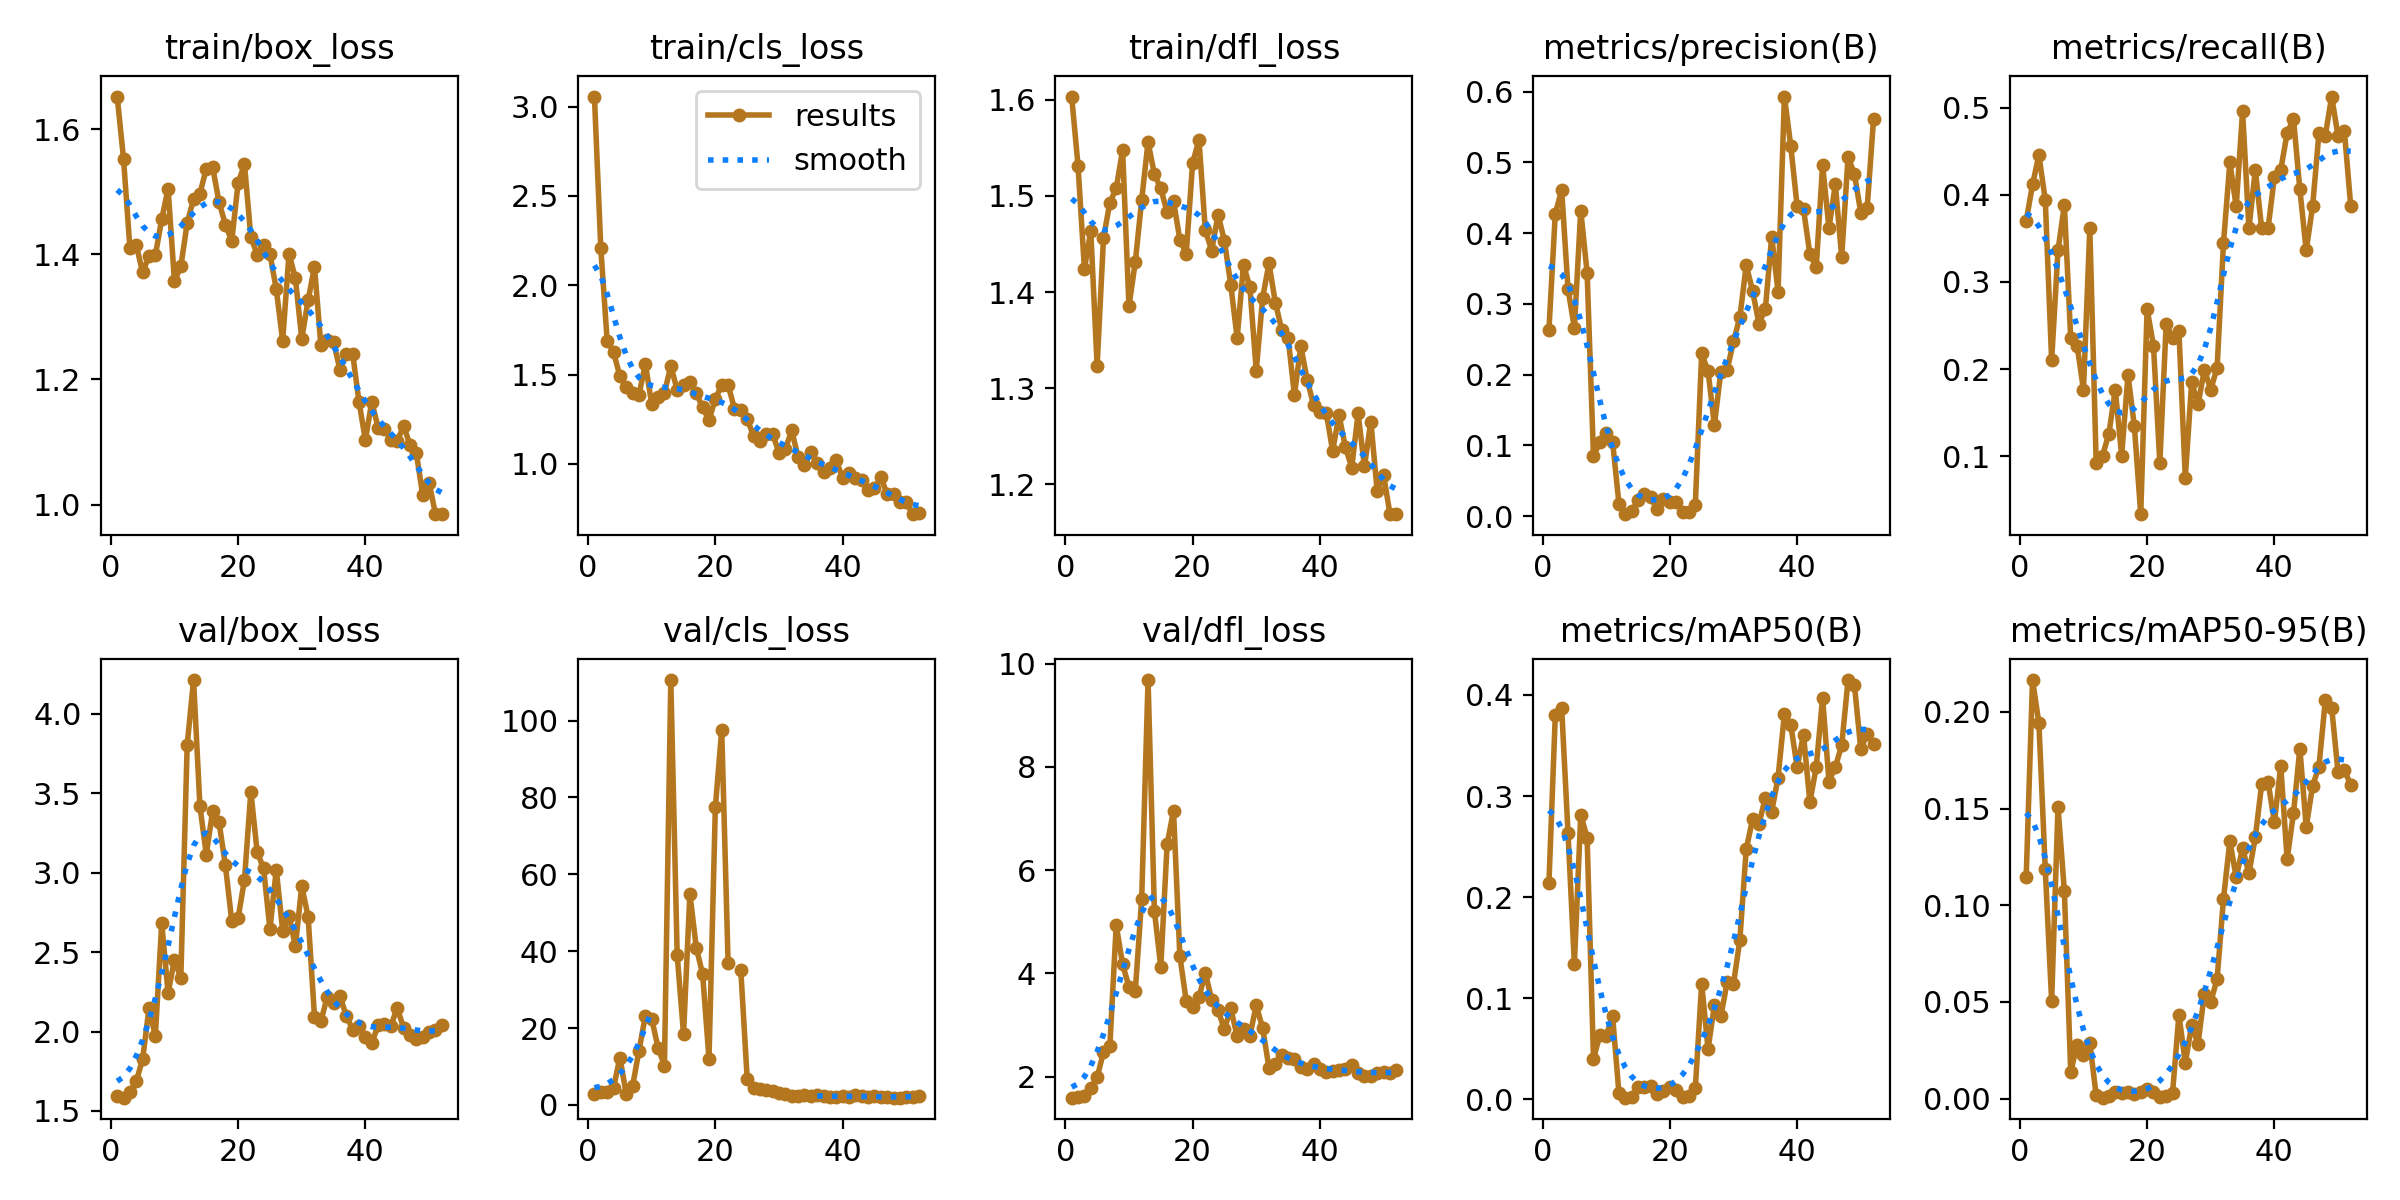

In [ ]:
Image.fromarray(cv2.imread(f"{RES_DIR}/results.png")) # прочитаем и выведем изображение с графиками

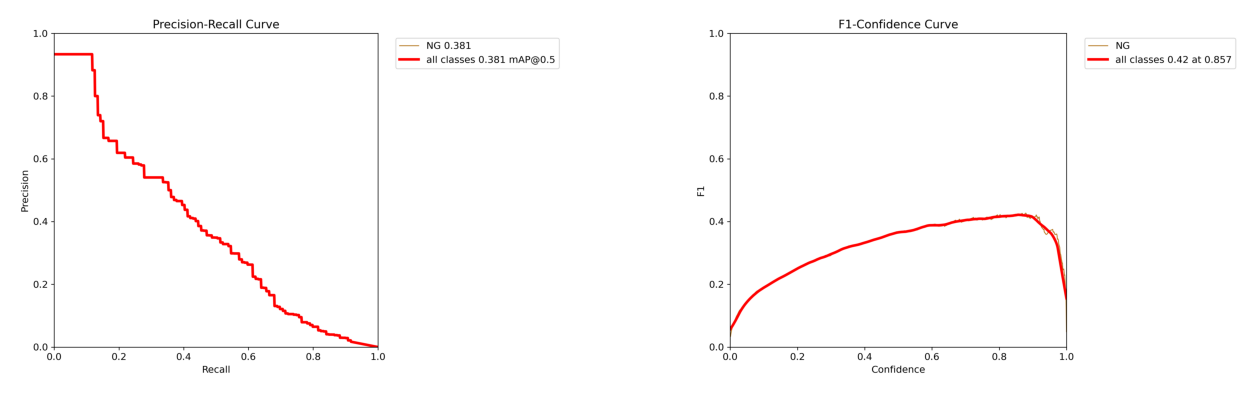

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
axes[0].axis("off")
axes[1].axis("off")
axes[0].imshow(cv2.imread(f"{RES_DIR}/PR_curve.png"))
axes[1].imshow(cv2.imread(f"{RES_DIR}/F1_curve.png"))

Ошибка уменьшается, метрики растут. Всё как надо! Но пока не очень понятно что всё это значит...

## Ошибки и метрики

##### Ошибки:


box_loss - ошибка ограничивающих рамок на базе IoU. IoU отражает степень пересечения между предсказанной и исходной ограничивающей рамкой и считается как отношение пересечения к объединению
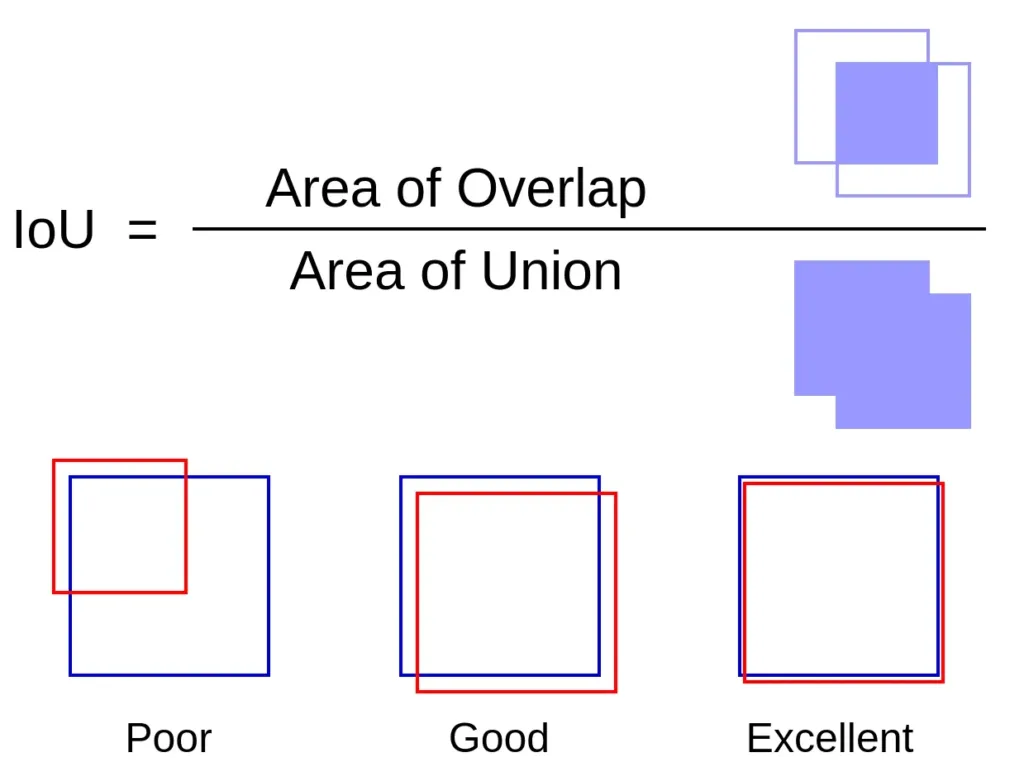

cls_loss - ошибка классификации объекта, используется для определения ошибки в предсказаниях относительно классов объектов.
В модели YOLO, каждый bounding box предсказывает не только координаты прямоугольника (bounding box) объекта, но также вероятности принадлежности к различным классам.

dfl_loss ([distribution focal loss](https://arxiv.org/pdf/2006.04388v1.pdf)) - прокаченная кроссэнтропия, берущая в учёт дисбаланс классов.
Focal Loss уделяет особое внимание "трудным" объектам, у которых низкая вероятность правильного предсказания. Это позволяет модели сосредоточиться на уменьшении ошибок предсказания для таких объектов, что существенно повышает точность обнаружения объектов.

##### Метрики:


Precision и recall метрики основываются на концепции таблицы истинности, в которой все предсказания могут быть отмечены как:
- **True Positive** - классификатор верно отнёс объект к рассматриваемому классу
- **True Negative** - классификатор верно утверждает, что объект не принадлежит к рассматриваемому классу
- **False Positive** - классификатор неверно отнёс объект к рассматриваемому классу
- **False Negative** - классификатор неверно утверждает, что объект не принадлежит к рассматриваемому классу




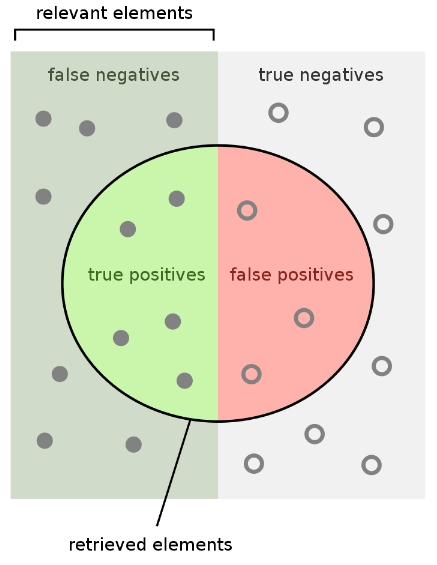

```precision``` (точность) - доля верно обнаруженных объектов из всех предсказаний

$precision = \dfrac{TP}{TP + FP}$



```recall``` (полнота) - доля верно обнаруженных объектов из всех объектов на фото

$recall = \dfrac{TP}{TP + TN}$

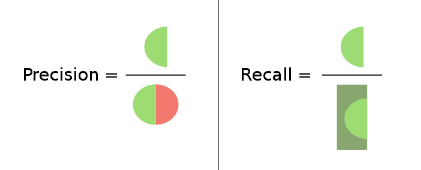

``F-1`` - гармоническое среднее от ``precision`` и ``recall``. Она нужна если нам важна, как точность, так и полнота. Выбранная для метрики формула выдаёт значения ниже, если один из параметров отстаёт от другого. Обычно визуализируется графиком с зависимостью от значений уверенности в предсказании (confidence).

$F1=\dfrac{2*precision*recall}{precision+recall}$

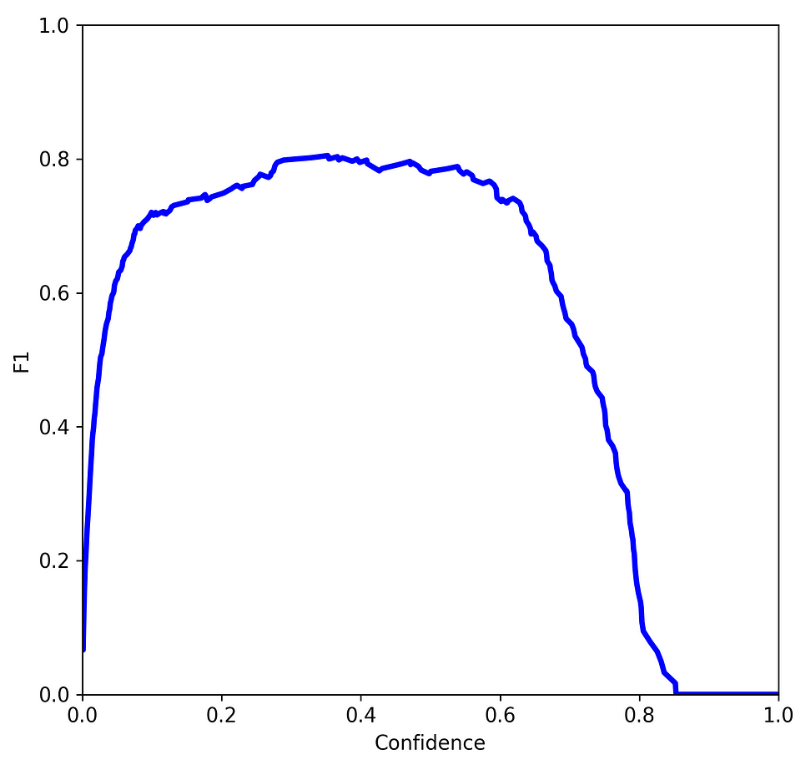

``PR Curve`` - precision-recall кривая. Отражает взаимосвязь между значениями точности и полноты на каждом новом предсказании. На каждом предсказании отмечается точка с координатами x=recall и y=precision.

<div style="display : flex;">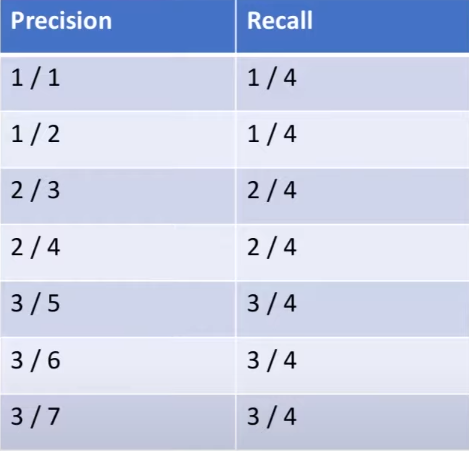
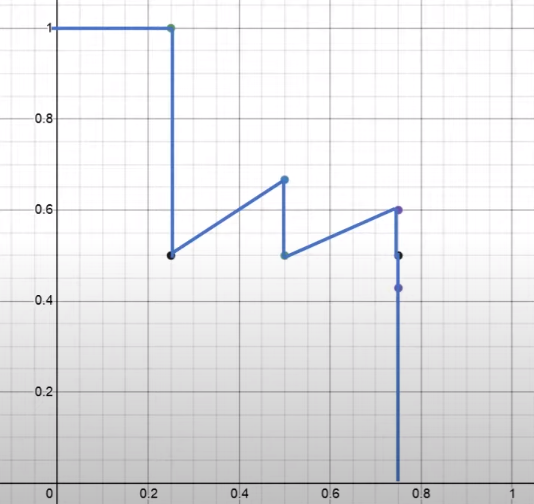
</div>

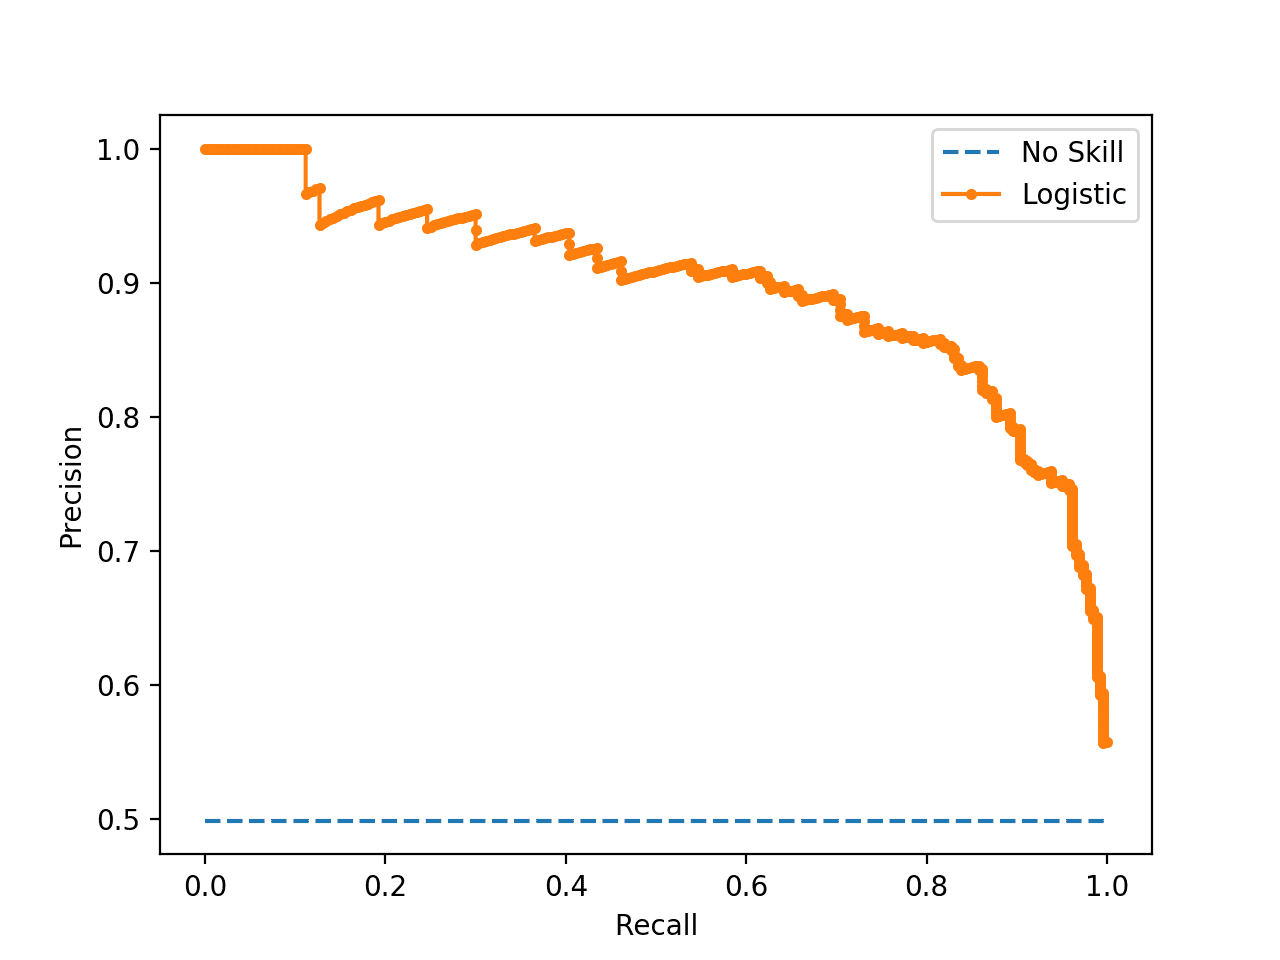

``AP`` (Average Precision) - метрика, рассчитываемая как площадь под PR-кривой конкретного класса.

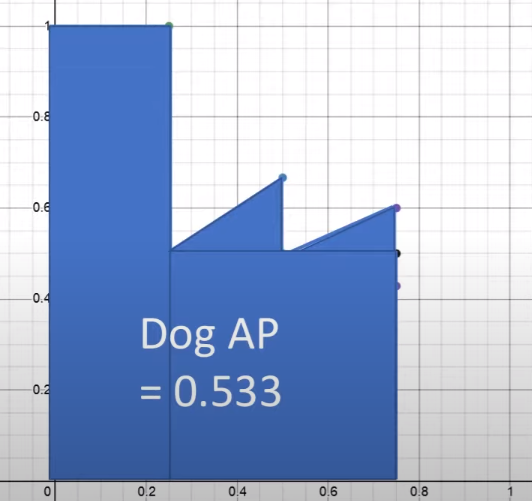

``mAP`` (mean AP) - среднее значение AP по всем классам.

``mAP50`` - среднее значение AP, высчитываемое только для предсказаний с IoU выше 50%

``mAP50-95`` -- `mean(mAP50, mAP55, mAP60, ..., mAP95)`. Первая цифра - нижний порог, вторая - верхний. Шаг по дефолту - 5%.

``mAP@0.5:0.05:0.95`` более явный формат записи со всеми 3 значиениями

## Результат обучения

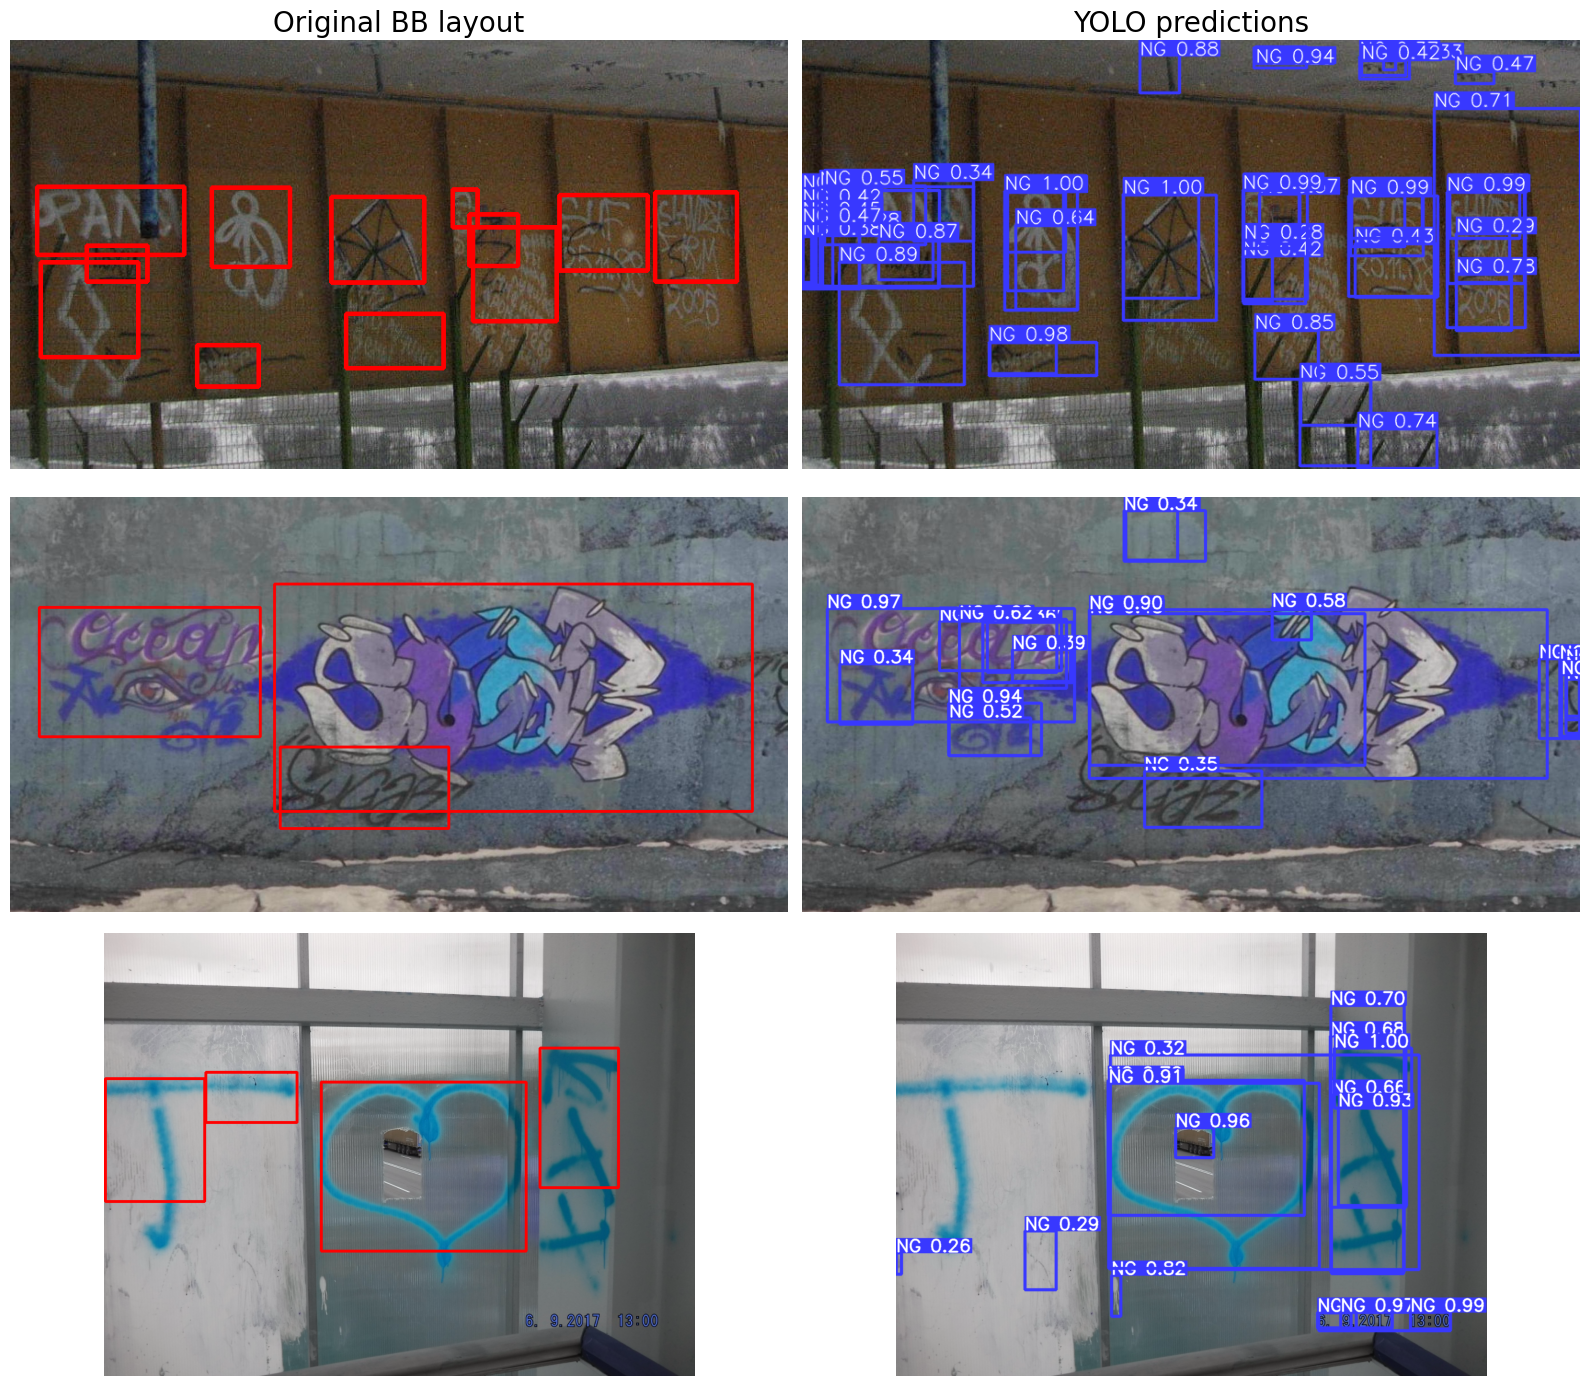

In [ ]:
compare_with_original(results, "test")

## Экспорт

Экспорт модели позволяет переводить её из формата одного фреймворка в другой.

Вот список всех поддерживающихся форматов:


|Format|`format` Argument|Model|Metadata|Arguments|
|---|---|---|---|---|
|[PyTorch](https://pytorch.org/)|-|`yolov8n.pt`|✅|-|
|[TorchScript](https://pytorch.org/docs/stable/jit.html)|`torchscript`|`yolov8n.torchscript`|✅|`imgsz`, `optimize`|
|[ONNX](https://onnx.ai/)|`onnx`|`yolov8n.onnx`|✅|`imgsz`, `half`, `dynamic`, `simplify`, `opset`|
|[OpenVINO](https://docs.ultralytics.com/integrations/openvino/)|`openvino`|`yolov8n_openvino_model/`|✅|`imgsz`, `half`, `int8`|
|[TensorRT](https://developer.nvidia.com/tensorrt)|`engine`|`yolov8n.engine`|✅|`imgsz`, `half`, `dynamic`, `simplify`, `workspace`|
|[CoreML](https://github.com/apple/coremltools)|`coreml`|`yolov8n.mlpackage`|✅|`imgsz`, `half`, `int8`, `nms`|
|[TF SavedModel](https://www.tensorflow.org/guide/saved_model)|`saved_model`|`yolov8n_saved_model/`|✅|`imgsz`, `keras`, `int8`|
|[TF GraphDef](https://www.tensorflow.org/api_docs/python/tf/Graph)|`pb`|`yolov8n.pb`|❌|`imgsz`|
|[TF Lite](https://www.tensorflow.org/lite)|`tflite`|`yolov8n.tflite`|✅|`imgsz`, `half`, `int8`|
|[TF Edge TPU](https://coral.ai/docs/edgetpu/models-intro/)|`edgetpu`|`yolov8n_edgetpu.tflite`|✅|`imgsz`|
|[TF.js](https://www.tensorflow.org/js)|`tfjs`|`yolov8n_web_model/`|✅|`imgsz`, `half`, `int8`|
|[PaddlePaddle](https://github.com/PaddlePaddle)|`paddle`|`yolov8n_paddle_model/`|✅|`imgsz`|
|[ncnn](https://github.com/Tencent/ncnn)|`ncnn`|`yolov8n_ncnn_model/`|✅|`imgsz`, `half`|


Универсальным форматом, который поддерживает конвертацию из любого и в любой фремворк - ONNX.

**ONNX** - Open Neural Network Exchange.

Чтобы выгрузить в него YOLO, достаточно одной строчки:

In [ ]:
model.export(format='onnx')

Да, так просто.

Поздравляем! Модель готова в продакшн!